# Chapter 11 – Deep Learning

 1. Vanishing/Exploding Gradients Problems
 2. Reusing Pretrained Layers
 3. Faster Optimizers
 4. Avoiding Overfitting Through Regularization
 5. Practical Guidelines
 
 
10장의 2개의 hidden layer를 사용한 DNN 보다 더 깊은 DNN 문제를 학습해야 할 때 발생하는 문제는 다음의 세가지이다. 
1. 깊은 신경망에 영향을 미치는 기울기가 사라지는 vanishing gradients 문제 (OR 발산해버리는 exploding gradients)->하위 layer에서 학습하는 것을 매우 어렵게 만든다.
2. 대규모 네트워크에서의 교육이 매우 느리다는 점
3. 수백만 개의 파라미터가 있는 모델은 학습 세트를 overfitting 할 위험

이 장에서 다룰 내용은 1) Vanishing Gradients, 2) 다양한 Gradient Descent 방법, 3) 다양한 Optimizer 방법 이다. 

# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 1. Vanishing/Exploding Gradients Problem


* Vanishing 문제 <br>
역 전파(backpropagation) 알고리즘은 output layer에서 input layer로 이동하면서 error gradient를 전파한다. <br>
알고리즘은 네트워크의 각 파라미터와 관련하여 비용 함수(cost function)의 gradient를 계산하여, 각 파라미터를 gradient descent 단계로 갱신한다. 알고리즘이 하위 layer로 진행함에 따라, gradient는 점점 작아진다.<br<br>
즉 layer를 지날 때마다 최초 값보다 현저하게 작아지기 때문에 값을 전달해도 의미가 없다. <br>
결과적으로 Gradient Descent 업데이트는 output layer의 연결 가중치(connection weights)를 거의 반영하지 않으며, 이는 결국 좋은 솔루션으로 수렴하지 않는다.<br>
<br>

* Exploding 문제<br>
반대로 기울기가 커져 layer가 진행됨에 따라 대폭 업데이트되면 알고리즘은 발산(diverge)하게 된다. <br>
주로 RNN(recurrent neural networks)에서 발생하는 문제이다.<br>


<Xavier Glorot와 Yoshua Bengio의 의문점>
1) logistic sigmoid 활성화함수
2) 평균 0과 표준편차 1의 정규분포를 사용하는 무작위 초기화로 사용된 가중치 초기화(weight initialization)

logistic 활성화 함수를 보면 input 값이 커지면 (음수 또는 양수) 함수가 0또는 1로 포화되고 도함수(미분계수;derivative)는 0에 가까워짐을 알 수 있다. 
<br>따라서 역 전파가 시작 될 때, 네트워크를 통해 다시 전파 될 수 있는 gradient가 거의 없다.<br>
역 전파가 최상위 layer를 통해 진행됨에 따라 gradient는 희박해지기 때문에 하위 layer에는 아무 것도 남지 않는다. 

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


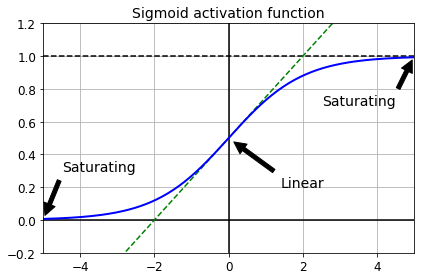

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## 1.1Xavier and He Initialization

앞서 얘기한 문제를 완화시키기 위해서 신호가 양방향 즉, 예측을 할 때 앞 방향으로, gradient를 역 전파 할 때 반대 방향으로 신호가 적절히 흐르도록 input의 분산과 같도록 각 layer의 output의 분산이 필요하다고 주장한다. 

아래 식과 같이, 연결 가중치는 무작위로 초기화해야 한다. <br>
여기에서 n_inputs과 n_outputs은 가중치가 초기화되는 input 및 output의 connections 수이다. (fan-in과 fan-out 이라고도 함)<br>
이 초기화 전략은 "Xavier initialization 또는 Glorot initialization" 이라고도 한다.
<img src='11-1.PNG'>

 Xavier 초기화 전략을 사용하면 학습 속도가 상당히 빨라 질 수 있으며, 이는 딥러닝의 현재 성공을 이끌어 낸 트릭 중 하나이다. <br>
 각 활성화함수의 파라미터 초기화 식은 다음과 같다. 
 <img src='11-1.PNG'>
 
 ReLU 활성화 함수(그리고 변형된 ELU활성화를 포함하여)에 대한 초기화 전략은 때때로 He initialization 이라고도 부른다.


Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

10장에서 소개한 tf.layers.dense() 함수는 균일 분포(uniform distribution)인 Xavier initialization을 사용한다. <br>
다음과 같이 `variance_scaling_initializer()` 함수를 사용하여 He initialization으로 변경 할 수 있다.<br>
He initialization는 Xavier initialization과 같이 fan-in과 fan-out 사이의 평균이 아닌 fan-in만 고려한다

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## 1.2 Nonsaturating Activation Functions
vanishing/exploding gradients 문제는 부분적으로 활성화 함수를 잘못 선택 되었기 때문에 발생한 것이다.<br> 
대부분의 사람들은 sigmoid 활성화 함수를 사용하는 것을 훌륭하다고 생각했다. 

그러나 Deep Neural Network(DNN) 에서 다른 활성화 함수, 특히 ReLU 활성화 함수는 특히 더 잘 작동한다는 사실이 드러났다. <br>
대개 ReLU 활성화 함수는 양수(positive) 값에 대해 포화되지 않고 계산속도도 빠르기 때문이다<br>

그러나 ReLU 함수는 완벽하지 않다. 'dying ReLUs'라는 문제가 발생하는데 학습 동안 몇몇 뉴런이 실제적으로(effectively) 죽게되는것을 의미한다. <br> 이는 ReLU 함수가 0보다 낮은 값에서 Gradient 값이 0이외에 다른 값으로 출력되지 않기 때문이다. 

즉,  학습 도중 뉴런의 입력 가중치의 합(weighted sum of the neuron's inputs)이 음수가 되도록, 뉴런의 가중치(neuron's weights)가 업데이트 된다면, 0을 출력하게 될 것이다. <br> 
이런경우 해당 뉴런은 죽게된다. <br>

 이러한 문제를 해결하기 위해, **leaky ReLU** 와 같은 변형된 ReLU 함수를 사용할 수 있다
 $$LeakyReLU_{\alpha}(z)=max(\alpha z, z)$$
 α는 함수가 얼마나 많이 "leaks" 하는 지에 대해 정의하고 z<0 에 대한 함수의 gradient이며, 일반적으로 0.01로 설정된다
 leaky ReLU의 작은 경사면은 leaky한 ReLU가 절대 죽지 않도록 한다
 
 
 ### RReLU & PReLU
 Randomized leaky ReLU(RReLU) 
 - α는 학습 중 주어진 범위에서 무작위로 추출되며, 테스테를 할 때에는 평균 값으로 고정
 -  RReLU는 상당히 잘 수행되고, regularizer 로써의 역할을 수행하는 것처럼 보였다.(regularizer 역할을 수행했다는 것은, 훈련세트에서 과적합 되는 위험을 줄일 수 있었음을 말함)
 
parametric leaky ReLU(PReLU)
 -  PReLU에서 α는 역전파(back propagation)에 의해 수정 될 수 있는 파라미터 값
 -  PReLU는 큰 이미지 데이터 세트에서 ReLU보다 강력하기 뛰어난 것으로 보고되었지만, 작은 이미지 데이터 셋에서 학습세트가 과적합 될 수 있는 위험

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


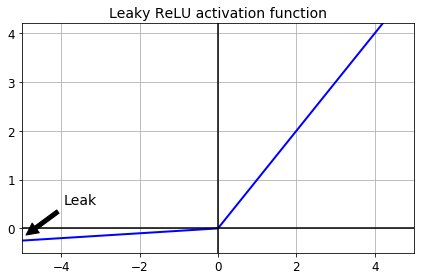

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

leaky ReLU에 대해 미리 정의된 함수는 없지만 정의하기 매우 쉽다. alpha값으로는 0.01로 설정

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [19]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9508
10 Batch accuracy: 0.96 Validation accuracy: 0.9666
15 Batch accuracy: 1.0 Validation accuracy: 0.9722
20 Batch accuracy: 1.0 Validation accuracy: 0.975
25 Batch accuracy: 1.0 Validation accuracy: 0.9766
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 0.96 Validation accuracy: 0.9792


### ELU
2016년  모든 ReLU 변형을 능가하는 새로운 활성화 함수 exponential linear unit(ELU)가 제안됨 <br>
ELU는 학습시간을 단축되고, 신경망이 테스트 세트에서 더 잘 수행됨을 확인
<img src='11-3.PNG'>

**ReLU와 ELU의 차이점**
- z<0 일 때, 음의 값을 취하여 단위가 0에 가까운 평균 출력을 갖는다. 이전에 논의한 것처럼 vanishing gradient 문제를 완화하는 데 도움이 된다. 파라미터 α는 z가 큰 음수일 때 ELU 함수가 접근하는 값을 정의한다. 일반적으로 1로 설정 되지만, 다른 파라미터처럼 조정 가능하다.

- z<0에 대해 0이 아닌 gradient를 가지기 때문에, dying units 문제를 피할 수 있다.

- 함수는 z=0 주변을 포함하여 모든 면에서 smooth하다. 그렇기 때문에 gradient descent의 속도를 높이는데 도움이 된다

**ELU의 단점**
- 지수 함수의 사용으로 인해 ReLU와 그 변형에 비해 느리게 계산된다. 학습 동안에는 더 빠른 convergence rate 로 보상을 받기는 하지만, 테스트 시간에 ELU는 ReLU 보다 느리다.

**TIP**<br>
hidden layer에 사용되는 활성화함수는 일반적으로 ELU > leaky ReLU(또는 그 변형) > ReLU > tanh > sigmoid 을 사용한다.<br>
만약 런타임 성능이 중요하다면 ELU 보다 leaky ReLU를 선호하고 다른 파라미터를 조정하고 싶지 않다면 기본값 α를 사용할 수 있다.<br>
(leaky ReLU의 경우 0.01, ELU의 경우 1)<br>
여유 시간과 컴퓨팅 파워가 있다면, cross validation을 이용하여 다른 활성화 함수를 이용할 수 있고 <br>
특히 네트워크가 과적합하다면, RReLU를, 학습 세트가 너무 많을 경우에는 PReLU를 이용해 볼 수 있다.

In [20]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

`elu()` :  `dense()` 함수를 호출 할 때, activation 인수를 설정해주면 된다. 

Saving figure elu_plot


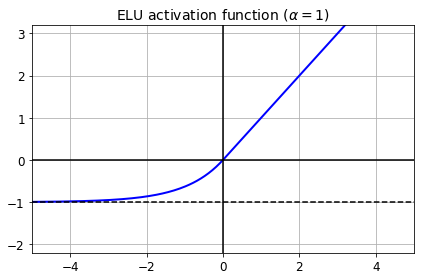

In [21]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [23]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [24]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


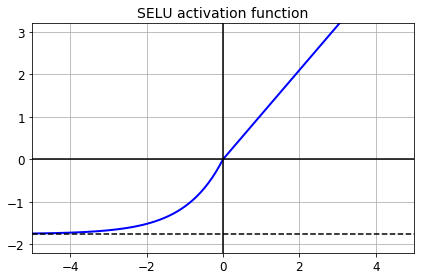

In [25]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [26]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


Here's a TensorFlow implementation (there will almost certainly be a `tf.nn.selu()` function in future TensorFlow versions):

In [27]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELUs can also be combined with dropout, check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz.

Let's create a neural net for MNIST using the SELU activation function:

In [28]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [29]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.924
5 Batch accuracy: 1.0 Validation accuracy: 0.9568
10 Batch accuracy: 0.94 Validation accuracy: 0.9668
15 Batch accuracy: 0.98 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9712
25 Batch accuracy: 1.0 Validation accuracy: 0.9694
30 Batch accuracy: 1.0 Validation accuracy: 0.97
35 Batch accuracy: 1.0 Validation accuracy: 0.971


# 1.3 Batch Normalization
ELU와 He initialization을 사용하여 학습시작시 vanishing/exploding gradients문제를 줄일 수 있지만 학습도중 다시 발생할 수 있다. <br>

2015년 Segey Ioffe와 Christian Szegedy에 의해 vanishing/exploding 문제를 처리하기 위한 Batch Normalization(BN)이라는 기술이 제안됨<br>
학습 동안, 이전 layer의 파라미터가 변경됨으로써, 각 layer들의 입력 분포(input distribution)가 변경되는 internal Covariate Shitf라 불리는 문제를 해결했다.<br>

이 기법은 각 layer의 activation function 직전에 모델에 **operation**을 추가하고, 간단히 input값들을 zero-centering 과 normalizing을 한다. <br>그 다음, layer 당 두 개의 새로운 파라미터를 사용하여 결과를 scaling 하고, shifting 하는 것으로 구성된다. <br>
즉 하나의 파라미터는 scaling용이며, 다른 하나는 shifting 용이다.<br>
이 operation을 통해 모델은 각 layer의 input에 대해 최적의 크기(optimal scale)와 평균을 학습할 수 있다. 
 
input들을 중심에 맞추고(zero-center) normalization 하기 위해 알고리즘은, input들의 평균 및 표준 편차를 추정해야 한다. <br>
이것은 현재 mini-batch를 통해 평균 및 표준편차를 평가한다. (따라서 batch normalization 이라고 부른다.)
<img src='11-4.PNG'>

- $μ_B$는 전체 mini-batch B에서 평가 된 경험적 평균(표본 평균, empirical mean)
- $σ_B$는 경험적 표준 편차(표본 표준편차, empirical standard deviation)이며, 전체 mini-batch를 통해 평가됨
- $m_B$는 mini-batch의 인스턴스 수
- hatx(i)는 중심에 맞춰진(zero-centered) 정규화(normalization) 된 input
- γ는 layer의 scaling 파라미터
- β는 layer의 layer의 shifting 파라미터 (offset)
- ε은 0으로 나누는 것을 피하기위한 작은 숫자로 일반적으로 10의 -5승. 또한 smoothing term 이라고도 부름
- z(i)는 BN operation의 output값. 입력의 scaled 및 shifted 된 버전


테스트 할 때에는, 경험적 평균과 표준편차를 계산 할 mini-batch가 없으므로, 대신 전체 학습 세트의 평균 및 표준편차를 사용해야 한다. <br>
이것들은 일반적으로 이동 평균(moving average)을 이용하여 학습 중에 효율적으로 계산된다. <br>
따라서 전체적으로 각 batch-normalized layer에 4개의 파라미터가 학습된다. <br>
-> γ (scale), β (offset), μ (mean) 및 σ (standard deviation)

vanishing gradients문제는 tanh 및 logistic 활성화 함수와 같은 saturating 활성화 함수를 사용할 수 있을 정도로 해결되었고 네트워크는 가중치 초기화(weight initialization)에 훨씬 덜 민감했다.  <br> 
훨씬 더 큰 learning_rate를 사용할 수 있었고, 학습 과정의 속도를 크게 향상 시켰다.  <br>
구체적으로 최신식의(state of the art)이미지 분류 모델에 적용하여, BN은 14배 적인 학습 단계로 동일한 정확도를 달성하였다. <br>
또한, BN은 regularizer로 작동하여, 이번 챕터 후반기에 다룰 dropout과 같은 정규화 기법의 필요성을 줄여주었다.<br>

<단점><br>
BN은 모델이 복잡해지고 runtime 문제가 있다. : 각 layer에 요구되는 계산때문에 예측이 느려진다. <br>
예측을 빠르게 해야할 때는 BN 수행전에 ELU, He initialization이 잘 수행되는지 확인해야한다. 

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

### 1.3.1 Implementing Batch Normalization with TensorFlow
텐서플로우는 input을 중앙에 놓고, normalize하는 tf.nn.batch_normalization() 함수를 제공하지만, 사용자가 직접 평균 및 표준편차를 계산해야
한다.<br>
그리고 파라미터를 함수에 전달하고 scaling 및 offset 파라미터의 생성을 처리해야 한다. <br>
이것은 편리한 방법이 아니므로 다음 코드와 같이 이 모든 것을 처리하는 `tf.layers.batch_normalization()` 함수를 사용하면 된다. 

In [30]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')
# 현재 mini-batch의 평균 및 표준편차, 테스트 중에는 전체 학습 데이터 셋의 평균 및 표준 편차를 사용해야 
# 하는지에 대한 여부를 tf.layers.batch_normalization() 함수에 알리는 데 사용

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")  # 특정 활성화 함수를 지정하지는 않는다 -> BN layer 다음에 지정
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9) # training과 momentum 설정
# running average를 계산하기 위해 exponential decay를 사용하기 때문에 momentum 파라미터가 필요하다.

# running average(이동평균):  어떤 일정시점까지 급수(합)의 평균을 의미
# exponential decay : 어떤 양이 그 양에 비례하는 속도로 감소 

bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

running average를 계산하기 위해 exponential decay를 사용하기 때문에 momentum 파라미터가 필요하다.<br>
running average(이동평균):  어떤 일정시점까지 급수(합)의 평균을 의미<br>
exponential decay : 어떤 양이 그 양에 비례하는 속도로 감소 <br>

In [31]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

좋은 momentum 값은 일반적으로 1과 가깝다<br>
동일한 batch normalization 파라미터가 반복해서 나타나는 코드가 되풀이 되는 것을 알 수 있다. <br>
이 반복을 피하기 위해, 파이썬에서 표준 라이브러리인 function모듈의 partial() 함수를 사용할 수 있다. <br>
함수 주위에 얇은 래퍼를 작성하고, 일부 파라마터에 대한 기본값을 정의할 수 있다<br>

In [2]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9) # parital()함수를 사용

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

NameError: name 'tf' is not defined

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [33]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [34]:
n_epochs = 20
batch_size = 200

### Execution phase 주의사항
    1.  학습 도중 batch_normalization() layer에 의존하는 연산을 실행 할 때마다, training placeholder를 True로 설정
    2.  batch_normalization() 함수는 이동 평균(moving/running average)을 업데이트 하기 위해 학습 중 각 단계에서 평가되어야 하는 몇가지 operation을 만든다.
    (이러한 이동 평균은 학습세트의 평균 및 표준 편차를 평가하는 데 필요함을 상기해야함)
    이러한 작업은 UPDATE_OPS 컬렉션에 자동으로 추가되므로, 모든 컬렉션 반복 작업에서 해당 컬렉션의 작업 목록을 가져와 실행하면 된다. 

In [35]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8727
1 Test accuracy: 0.8981
2 Test accuracy: 0.9129
3 Test accuracy: 0.922
4 Test accuracy: 0.9292
5 Test accuracy: 0.9342
6 Test accuracy: 0.9381
7 Test accuracy: 0.9419
8 Test accuracy: 0.9451
9 Test accuracy: 0.9471
10 Test accuracy: 0.9507
11 Test accuracy: 0.9521
12 Test accuracy: 0.9553
13 Test accuracy: 0.956
14 Test accuracy: 0.957
15 Test accuracy: 0.9583
16 Test accuracy: 0.9613
17 Test accuracy: 0.9608
18 Test accuracy: 0.9627
19 Test accuracy: 0.963


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [36]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0']

In [37]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## 1.4 Gradient Clipping
Gradient clipping은 exploding gradients 문제를 줄이기 위한 인기있는 기법<br>
역전파(backpropagation) 동안 임계값을 초과하지 않도록 하기 위해 gradient를 crip하는 방법<br>
일반적으로 사람들은 Batch Normalization을 선호하지만, 여전히 Gradient clipping에 대한 이해와, 구현하는 방법에 대해 아는 것은 유용함

In [38]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [39]:
learning_rate = 0.01

**Gradient Clipping 방법**<br>
1) 텐서플로우에서 optimizer's의 minimize() 함수는 gradients 계산과 적용을 처리하므로 optimizer's의 `compute_gradients()` 메소드를 먼저 호출<br>
2) `clip_by_value()` 함수를 사용하여 gradient를 clip하는 operation 생성<br>
3) `apply_gradients()` 메소드를 사용하여, clip 된 gradient를 적용하는 operation을 생성 <br>

In [40]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
# compute_gradients() 메소드 호출
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
# gradient 를 clip하는 operation 생성
training_op = optimizer.apply_gradients(capped_gvs)
# clip된 gradient를 적용하는 operation 생성

The rest is the same as usual:

In [41]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [42]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 20
batch_size = 200

In [44]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.3139
1 Test accuracy: 0.8001
2 Test accuracy: 0.8806
3 Test accuracy: 0.9037
4 Test accuracy: 0.9124
5 Test accuracy: 0.9197
6 Test accuracy: 0.9243
7 Test accuracy: 0.9299
8 Test accuracy: 0.9331
9 Test accuracy: 0.9387
10 Test accuracy: 0.9431
11 Test accuracy: 0.9445
12 Test accuracy: 0.9455
13 Test accuracy: 0.9485
14 Test accuracy: 0.9524
15 Test accuracy: 0.9511
16 Test accuracy: 0.9562
17 Test accuracy: 0.9583
18 Test accuracy: 0.9559
19 Test accuracy: 0.9605


## 2. Reusing Pretrained Layers
매우 큰 DNN을 처음부터 학습하는 것은 일반적으로 좋은 아이디어는 아니다. <br>
대신에, 진행하려는 과제와 유사한 작업을 수행하는 기존 신경망을 찾아서, 하위 계층을 재사용하는 방법이 있다. <br>
이를 **transfer learning**이라고 한다.  이는 학습 속도를 크게 높일뿐만 아니라, 학습 데이터도 훨씬 덜 필요로 한다.<br>


예를 들어 사진을 동물, 식물, 차량 및 일상적 물건 등 100가지 범주로 분류하도록 학습된 DNN에 액세스 할 수 있다고 가정해보자. <br>
이제 특정 차량 유형을 분류하기 위해 DNN을 학습해야 한다. 이러한 작업들은 매우 유사하므로 첫 번째 네트워크의 일부를 재사용 할 수있다.
<img src='11-5.PNG'>


### 2.1 Reusing a TensorFlow Model

원래 모델이 텐서플로를 사용하여 학습 된 것이라면, 간단히 복원하여 새 작업에 맞출 수 있다. <br>
9장에서 논의했듯이 `Import_meta_graph()` 함수를 사용하여 기본 그래프로 로드하고 모델 상태를 복원하는 데 사용할 수 있는 saver를 return한다. 
기본적으로 saver는 그래프의 구조를 .meta 파일에 저장한다.  (나중에 이 파일을 로드해야함)


In [45]:
reset_graph()

In [46]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [47]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/Const
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/Const
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [48]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [49]:
show_graph(tf.get_default_graph())

이때, 학습에 필요한 operation과 tensor에 대해 잘 다룰 수 있어야한다. <br>
이를 위해 그래프의 `get_operation_by_name()` 과 `get_tensor_by_name()` 메소드를 사용할 수 있다. <br>
텐서의 이름은 output operation의 이름이다: 0(or 1: 두번째 output, 2: 3번째 output, 등등)<br>

필요한 operation의 이름을 찾는 방법으로 텐서보드로 탐색을 하거나 그래프의 `get_operations()`를 사용하여 모든 작업을 확인할 수 있다.

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

만약 original model을 작성한 사람이라면, 모델을 재 사용할 사람들을 위해 명확한 이름을 지정하여 문서화 할 수 있다. <br>
또 다른 접근법은 사람들이 다루고자 하는 중요한 operation들을 포함하는 collection을 만드는 것이다. 


In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

위와 같이 만들면 모델을 재사용하는 사람들은 아래와 같이 간단하게 사용할 수 있다.

In [52]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

 그런 다음 Saver를 사용하여 모델의 상태를 복원하고 자신의 데이터를 이용하여 학습을 계속 할 수 있다.

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


실제 TEST 하기

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9609
1 Test accuracy: 0.9608
2 Test accuracy: 0.9617
3 Test accuracy: 0.9613
4 Test accuracy: 0.9639
5 Test accuracy: 0.9649
6 Test accuracy: 0.9663
7 Test accuracy: 0.9627
8 Test accuracy: 0.9665
9 Test accuracy: 0.9669
10 Test accuracy: 0.9662
11 Test accuracy: 0.9674
12 Test accuracy: 0.9678
13 Test accuracy: 0.9679
14 Test accuracy: 0.9688
15 Test accuracy: 0.9684
16 Test accuracy: 0.9687
17 Test accuracy: 0.9702
18 Test accuracy: 0.9673
19 Test accuracy: 0.9687


또는 original 그래프를 작성한 파이썬 코드에 액세스 할 수 있는 경우 `import_meta_graph()` 를 사용 할 수 도있다. 

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9611
1 Test accuracy: 0.9619
2 Test accuracy: 0.9622
3 Test accuracy: 0.9619
4 Test accuracy: 0.9644
5 Test accuracy: 0.9633
6 Test accuracy: 0.9647
7 Test accuracy: 0.9648
8 Test accuracy: 0.9671
9 Test accuracy: 0.9677
10 Test accuracy: 0.9676
11 Test accuracy: 0.9679
12 Test accuracy: 0.9687
13 Test accuracy: 0.9688
14 Test accuracy: 0.9683
15 Test accuracy: 0.9693
16 Test accuracy: 0.9677
17 Test accuracy: 0.9697
18 Test accuracy: 0.9692
19 Test accuracy: 0.9707


In [57]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [58]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9142
1 Test accuracy: 0.9346
2 Test accuracy: 0.9437
3 Test accuracy: 0.9486
4 Test accuracy: 0.9517
5 Test accuracy: 0.9544
6 Test accuracy: 0.9544
7 Test accuracy: 0.9562
8 Test accuracy: 0.9588
9 Test accuracy: 0.9619
10 Test accuracy: 0.9617
11 Test accuracy: 0.9617
12 Test accuracy: 0.9624
13 Test accuracy: 0.9644
14 Test accuracy: 0.9622
15 Test accuracy: 0.964
16 Test accuracy: 0.9666
17 Test accuracy: 0.9668
18 Test accuracy: 0.9673
19 Test accuracy: 0.9687


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

보통은 original 모델의 일부만을 다시 사용하길 원한다. <br>
`import_meta_graph()`를 사용하여 그래프를 restore하면, 원본 그래프 전체가 로드 되지만, 다루지않는 layer들이 무시되는 것은 막을 방법이 없다. <br>
<img src='11-5.PNG'>
예를 들어, 위에 그림에서 보인 것처럼 사전 학습 된 layer(예: 사전 학습된 hidden layer 3) 위에 새로운 layer(예: one hidden layer, one output layer)를 만들 수 있다. <br>
또한 새로운 output에 대한 손실(loss)을 계산하고, 해당 손실을 최소화 할 수 있는 optimizer를 생성해야한다. <br>


사전 학습 된 그래프의 파이썬 코드에 액세스 할 수 있다면 필요한 부분을 다시 사용하고 나머지 부분을 잘라낼 수 있다.<br>
그러나 이러한 경우에는 사전 학습 된 모델을 복원하기 위해 Saver 및 새로운 모델을 저장하기 위한 다른 Saver를 필요로 한다. <br>
예를 들어 아래 코드는 hidden layer 1, 2 그리고 3만 복원한다. 

In [60]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                      # not shown in the book
        for iteration in range(mnist.train.num_examples // batch_size): # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  # not shown
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # not shown
                                                y: mnist.test.labels}) # not shown
        print(epoch, "Test accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9022
1 Test accuracy: 0.9302
2 Test accuracy: 0.9393
3 Test accuracy: 0.9429
4 Test accuracy: 0.9484
5 Test accuracy: 0.9511
6 Test accuracy: 0.9517
7 Test accuracy: 0.9539
8 Test accuracy: 0.9545
9 Test accuracy: 0.9572
10 Test accuracy: 0.9599
11 Test accuracy: 0.9602
12 Test accuracy: 0.9606
13 Test accuracy: 0.9619
14 Test accuracy: 0.9619
15 Test accuracy: 0.9636
16 Test accuracy: 0.9633
17 Test accuracy: 0.9643
18 Test accuracy: 0.9651
19 Test accuracy: 0.9657


- 먼저 original 모델의 hidden layer 1~3을 복사하여 새로운 모델을 만든다. <br>
- 정규표현식 "hidden[123]"을 사용하여 hidden layer 1~3의 모든 변수 목록을 가져온다. <br>
- original 모델의 각 변수 이름을 새 모델의 이름으로 매핑하는 dictionary를 만든다. (일반적으로 동일한 이름을 유지하는 경우)<br>
- 이러한 변수들만 복원할 Saver를 만든다. 
- 모든 변수(old and new)를 초기화하는 operation을 만들고, 두번째 Saver는 layer1에서 3까지 뿐만아니라, 새로운 모델 전체를 저장한다.<br>
- 세션을 열어 모델의 모든 변수를 초기화 한 다음 변수를 복원한다. 값은 original 모델의 layer1~3까지이다. <br>
- 마지막으로 새로운 task에 대한 모델을 학습하고 이를 저장한다.


### 2.2 Reusing Models from Other Frameworks

다른 프레임워크를 사용하여 학습 된 모델이라면, 수동적으로 모델의 파라미터를 load 해야한다.<br>
그런 다음 해당 파라미터를 적절한 변수에 할당해야 한다. <br>

이러한 작업은 매우 반복적이며 지루한 일이다. <br>
예를 들어, 다음 코드는 다른 프레임워크를 사용하여 학습 된 모델의 첫 번째 hidden layer에서 weight와 bias를 복사하는 방법이다. 

In [61]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [62]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[  61.   83.  105.]]


- 먼저 다른 프레임워크를 이용하여 사전에 학습된 모델을 load하고, 재사용하려는 모델 파라미터를 추출한다. 
- 다음으로 이전과 같이 텐서플로우 모델을 구축한다. 
- 모든 텐서플로우 변수에는 해당 변수를 초기화하는 데 사용되는 관련 할당 operation이 있다. 이러한 할당 operation(변수 이름과 같고 /Assign을 덧붙임)을 처리한다. 
- 각 assignment operation's의 두 번째 input값을 처리할 수 있어야 된다. 
- assignment operation의 경우, 두 번째 input은 변수에 할당 될 값에 해당하므로 이 경우 변수의 초기화 값이다. 

일단 세션을 시작하면 일반적인 초기화 operation을 수행하지만, 이번에는 우리가 재사용하기를 원하는 변수에 대해 원하는 값을 입력한다. 
또는, 새 assignment operation과 placeholders를 만들어서 초기화 후에 변수 값을 설정하는 데 사용할 수 있다. 

In [63]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [64]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [65]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### 2.3 Freezing the Lower Layers
첫 번째 DNN의 하위 layer에서 이미지의 low-level features에 대해 감지하기 위해 이미 학습했다면, 이러한 layer을 그대로 재사용 할 수 있다.<br>
새로운 DNN을 학습할 때 일반적으로 가중치를 'freeze" 하는 것이 좋다. 하위 layer 가중치가 고정 된 경우, 상위 layer 가중치를 쉽게 조정할 수
있다.(moving target을 학습할 필요가 없기 때문에)<br>
학습 중에 하위 layer를 고정하려면 하나의 솔루션으로 하위 layer의 변수를 제외하고, 최적화 할 수 있는 변수 목록을 제공해준다.

In [67]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [68]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

- train_vars 라인은 hidden layer3, 4와 output layer에 있는 모든 학습 가능한 변수의 목록을 가져온다. 
- hidden layer 1,2의 변수는 제외된다. 
- 다음으로 이 제한된 변수 목록을 optimizer's의 minimize() 함수에 적용한다. 
- layer1과 2는 frozen되어 있다. 학습 중에는 움직이지 않는다. (frozen layers)
- 또 다른 옵션은 그래프에 stop_gradient() layer를 추가하는 것이다. 그 아래의 모든 layer는 frozen된다. 


In [69]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [70]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8987
1 Test accuracy: 0.9311
2 Test accuracy: 0.9375
3 Test accuracy: 0.9414
4 Test accuracy: 0.9437
5 Test accuracy: 0.9479
6 Test accuracy: 0.9495
7 Test accuracy: 0.9521
8 Test accuracy: 0.9517
9 Test accuracy: 0.9525
10 Test accuracy: 0.9535
11 Test accuracy: 0.9538
12 Test accuracy: 0.9534
13 Test accuracy: 0.9546
14 Test accuracy: 0.9538
15 Test accuracy: 0.9553
16 Test accuracy: 0.9552
17 Test accuracy: 0.9549
18 Test accuracy: 0.9553
19 Test accuracy: 0.9557


In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [72]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [73]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9031
1 Test accuracy: 0.932
2 Test accuracy: 0.94
3 Test accuracy: 0.9435
4 Test accuracy: 0.9473
5 Test accuracy: 0.9492
6 Test accuracy: 0.9498
7 Test accuracy: 0.9493
8 Test accuracy: 0.9515
9 Test accuracy: 0.9519
10 Test accuracy: 0.9529
11 Test accuracy: 0.9536
12 Test accuracy: 0.9529
13 Test accuracy: 0.9532
14 Test accuracy: 0.9522
15 Test accuracy: 0.9534
16 Test accuracy: 0.953
17 Test accuracy: 0.955
18 Test accuracy: 0.955
19 Test accuracy: 0.9552


### 2.4 Caching the Frozen Layers

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [76]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

- frozen layer는 변경되지 않으므로, 각 학습 인스턴스에 대해 가장 상위에 frozen된 layer의 출력을 cache할 수 있다. 
- 학습은 전체 데이터 셋트를 여러 번 거쳐야하기 때문에, 학습 인스턴스 당 한 번만(epoch당 한번이 아닌) frozen layer를 통과하면 되므로 속도가크게 향상된다. 
- 예를 들어, 충분한 RAM이 있다고 가정하고, 먼저 하위 layer를 통해 전체 학습 셋을 실행 한 다음, 학습 동안 학습 인스턴스의 일괄 처리(batch)를 하는 대신에, hidden layer2로부터 output의 batch를 빌드하여 학습 operation에 그것들을 feed할 수 있다.


In [77]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # not shown
                                                y: mnist.test.labels})  # not shown
        print(epoch, "Test accuracy:", accuracy_val)                    # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9033
1 Test accuracy: 0.9322
2 Test accuracy: 0.9423
3 Test accuracy: 0.9449
4 Test accuracy: 0.9471
5 Test accuracy: 0.9477
6 Test accuracy: 0.951
7 Test accuracy: 0.9507
8 Test accuracy: 0.9514
9 Test accuracy: 0.9522
10 Test accuracy: 0.9512
11 Test accuracy: 0.9521
12 Test accuracy: 0.9522
13 Test accuracy: 0.9539
14 Test accuracy: 0.9536
15 Test accuracy: 0.9534
16 Test accuracy: 0.9547
17 Test accuracy: 0.9537
18 Test accuracy: 0.9542
19 Test accuracy: 0.9547


### 2.5 Tweaking, Dropping, Replacing the Upper Layers
original의 output layer는 일반적으로 new task에 유용하지 않을 수 있고, 심지어 원하는 output의 개수가 없을 수도 있어, 대개 교체해서 사용한다.<br>
    
이와 유사하게 original model의 상위 hidden layer는 new task에 있어서 하위 layer보다 유용하지 않을 수 있다. 그 이유는 new task에 있어 가장 유용할 high-level features이 original task에서 가장 유용하게 쓰인 것과 상당히 다를 수 있기 때문이다. (즉 기본 base에 맞춰 상위의 것들은 목적에 따라 달라 질 수 있음). 재사용 할 layer의 올바른 수를 찾아야된다.  <br>
    
먼저 copied된 모든 layer를 먼저 freezing 한 다음, 모델을 학습하고, 성능을 확인해야 한다. 그런 다음 가장 최상위 hidden layer중 하나 또는 두개를 unfreezing하여 역전파(backpropagation)를 조정(tweak)하여 성능이 향상되는지 확인한다. 학습 데이터가 많으면 많을수록 unfreeze 할 수있는 layer가 늘어난다.  <br>
    
여전히 좋은 성능을 얻을 수 없고, 학습데이터가 거의 없는 경우, 상단의 hiden layer(s)를 제거하고, 나머지 hidden layer를 모두 freeze한다. 재사용 할 layer를 찾을 때까지 반복할 수 있다. 학습 데이터가 충분하다면 상위 hidden layer를 삭제하는 대신 교체하거나, hidden layer를 더 추가 해볼 수 있다. 


### 2.6 Model Zoos
 내가 쓰고 싶은 신경망과 유사한 학습된 신경망을 찾을 방법은??<br>
 첫 번째로 살펴볼 것은 분명히 자신의 모델 카탈로그에 있다. 이것은 모든 모델을 저장하고 구성하여 나중에 쉽게 검색 할 수 있는 좋은 이유 중
하나이다. <br>
 또 다른 옵션은 model zoo에서 검색하는 것이다. 많은 사람들이 다양한 작업을 대해 머신러닝 모델을 학습하고, 사전 학습 된 모델을 일반 대중
들에게 공개한다.<br>
 텐서플로우는 https://github.com/tensorflow/models 에서 자체 model zoo를 제공한다.<br>
 특히 VGG, Inception, ResNet과 같은 최신의 이미지 분류를 포함하여, 코드, 사전 학습 모델, 인기있는 이미지 데이터 셋을 다룬로드하는 툴 등을 포함한다. <br>
 또다른 인기있는 model zoo는 Caffe's의 model zoo이다. 이 곳에서 다양한 데이터셋(예를 들어, ImageNet, Places Database, CIFAL10등)에서 학
습 된 다양한 컴퓨터 비전 모델(예를 들어, LeNet, AlexNet, ZFNet, googLeNet 등)을 얻을 수 있다. 


### 2.7 Unsupervised Pretraining
어떠한 복잡한 작업을 수행하려고 했으나, 많은 학습 레이블 학습데이터가 없고, 불행히도 유사한 작업으로 학습 된 모델을 찾을 수 없을때는 어떻게 해결할까.<br>

물론 더 많은 학습용 데이터를 수집해야 하지만 이러한 작업이 너무 어렵거나 값이 비싸면, unsupervised pretraining을 수행 해 볼 수 있다. 

즉, 레이블이 없는 학습데이터로만 충분하다면, Restricted Boltzmann Machines이나 autoencoders(15장에서 다룰 예정) 와 같은 unsupervised feature detector algorithm을 이용하여 layer를 아래에서부터 차근차근 학습해나갈수 있다.


각 layer는 이전 학습된 layer의 output에 대해 학습 된다. (학습 된 layer을 제외한 모든 layer는 frozen 상태)<br>
모든 layer를 이 방법으로 학습하면 supervised learning(예: backpropagation)을 사용하여 네트워크를 fine-tune할 수 있다.<br>

다소 길고 지루한 과정이지만, 종종 좋은 결과를 도출한다. 실제로 Geoffrey Hinton과 그의 팀이 2006년에 사용한 이 기술은 신경망의 부활과 딥러닝의 성공으로 이끌어냈다. 2010년 전까지는 unsupervised pretraining(일반적으로 RBMs 사용)이 신경망의 표준(norm for deep nets)이었으며, vanishing gradients 문제가 완화 된 후에만 역전파를 이용하여 DNN을 학습하는 것으로 사용되었다. 그러나, unsupervised pretraining(오늘날 RBMs보다 autoencoders를 일반적으로 이용함) 은 여전히 복잡한 과제를 풀 때, 재사용 하려는 유사한 모델이 없거나, 레이블 된 학습 데이터가 부족한 경우 좋은 선택이다. 

<img src='11-6.PNG'>

### 2.7 Pretraining on an Auxiliary Task
마지막 옵션은 레이블 된 학습 데이터를 생성하거나, 쉽게 얻을 수 있는 보조 작업(auxiliary task)에 대한 첫 번째 신경망을 학습 한 다음, 실제 작
업을 위해 해당 네트워크의 하위 계층(lower layers)을 재사용하는 것이다. <br>

첫 번째 신경망의 하위 계층은 두 번째 신경망에서 재사용 할 수 있는 feture detectors을 배운다. <br>

예를 들어,  얼굴을 인식 할 수 있는 시스템을 구축하려는 경우, 각 개인에 대한 몇 장의 사진만 가지고 있다면, 좋은 분류기를 학습하기 위해 충
분하지 않다. 각 사람의 사진 수백 장을 모으는 것은 실용적이지 않다.  <br>
그러나 인터넷에서 임의의 사람들의 사진을 많이 수집하고, 두 개의 다른사진이 동일한 사람을 특징(feature)으로 하는지 여부를 감지하는 첫 번째 신경망을 학습할 수 있다. 이러한 네트워크는 얼굴에 대한 좋은 feature detector를 배우므로, 하위 layer를 재사용하면 학습 데이터를 거의 사용하지 않고도 훌륭한 얼굴 분류기를 학습할 수 있다.<br>

레이블이 없는 학습 예제를 수집하는 것은 다소 저렴하지만, 레이블을 지정하는 데 비용이 많이 든다. 이러한 경우 일반적인 기술은 모든 학습 예제를 "good" 으로 레이블을 지정한 다음 좋은 예제를 손상시켜 많은 새로운 학습 인스턴스를 생성하고, 이러한 손상된 인스턴스를 "bad"라는 레이블로 지정하는 것이다. 그런 다음 good or bad로 인스턴스들을 분류하기 위한 첫 번째 신경망을 학습 할 수 있다. 

예를 들어, 수백만 개의 문장을 다운로드하여 "good"으로 레이블을 추가한 후, 각 문장에서 단어를 무작위로 변경한 후 결과 문장에 대해 "bad"로 레이블을 추가할 수 있다. 신경망에서 "The dog sleeps"는 좋은 문장이지만, "The dog they"는 나쁜 문장이 될 것이다.

하위 layer를 재사용하는것은 많은 언어 처리 작업에 있어 도움이 될 것이다.<br>
또 다른  접근 방법은 각 학습 인스턴스에 대한 점수를 출력하도록 첫 번째 네트워크를 학습하고, 좋은 인스턴스의 점수가 나쁜 인스턴스의 점수
보다 적어도 약간의 margin만큼 큰지에 대해 확인하는 비용함수를 사용하는 것이다. 이를 **max margin learning** 이라고 한다. 

# 3. Faster Optimizers
-  매우 큰 심층 신경망(Deep Neural Network)을 학습하는 것은 고통스럽게 느릴 수 있다. 지금까지 학습을 가속화하고 더 나은 솔루션에 도달하는 4가지 방법에 대해 알아봤었다. 4가지라 함은, 
1) Applying a good initialization strategy for the connection weights
2) Using a good activation function
3) Using Batch Normalization
4) Reusing parts of a pretrained network 이다.

-  또 다른 속도 향상 방법으로 regular Gradient Descent optimizer보다 빠른 optimizer를 선택하는 방법이 있다. 이번 섹션에서는 가장 인기있는 것들에 대해 제시하고자 한다.
   
   - Momentum optimization
   - Nesterov Accelerated Gradient
   - AdaGrad
   - RMSProp
   - Adam optimization

### 3.1 Momentum optimization

- 1964년 Polyak이 제안하였고 볼링공의 경사면에서 굴러떨어지는 것에서 아이디어 얻었다.이전 기울기가 무엇인지에 대해 크게 영향을 받는다는 의미.
- 각 반복에서 momentum 벡터 m(learning rate η으로 곱한)에서 local gradient를 뺀 다음 이 momentum벡터를 단순히 추가하여 가중치를 업데이트 한다. 
- 즉, 속도가 아닌 가속도를 이용한다. 
- 일반적인 Gradient Descent는 상대적으로 느리다. 

<img src='11-16.png'>

- momentum이라는 새로운 파라미터 β를 도입한다.(0(high friction)과 1(no friction) 사이에서 설정)
- 일반적인 momentum 값은 0.9다
-  Gradient가 일정하게 유지되면 terminal velocity(즉, 가중치 업데이트의 최대크기)가 learning rate η에 1/(1-β)를 곱한 값(부호 무시)에 gradient를 곱한것과 동일한지에 대해 쉽게 확인할 수 있다.
- 신층신견망의 경우 Batch normalization을 사용하지 않기 때문에 상위 레이어는 종종 매우 다른 스케일의 입력을 갖는다. 이 때 momentum optimization을 사용하면 많은 도움이 된다.


- 한 가지 단점은, 튜닝 할 파라미터가 추가된다는 것이다. 그러나 momentum 값 0.9는 일반적으로 잘 잘독하며 거의 항상 gradient descent 보다 빠르다.


In [78]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

### 3.2 Nesterov Accelerated Gradient

- 1983년 Yurii Nesterov가 제안한 momentum optimization의 변형 : Nesterov momentum optimization == Nesterov Accelerated Gradient
- Nesterov Accelerated Gradient(NAG)는 비용함수의 기울기를 local position이 아닌, momentum의 방향으로 약간 앞당겨서 측정하는 아이디어
 <img src='11-15.png'>
- 기존의 momentum optimization과의 유일한 차이점은 기울기 θ가 아닌 θ+βm 에서 측정된다는 것
- 원래 위치에서 gradient를 사용하는 대신, 그 방향으로 조금 더 멀리 측정 한 gradient를 사용하는 것이 좀 더 정확하다. 
  (∇1은 시작 포인트 θ에서 측정된 비용함수의 기울기를 나타내며, ∇2는 θ+βm에 위치한 점의 기울기를 나타낸다).
- NAG는 기존 momentum optimization보다 더 빨리 최적화가이루어진다.


In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

### 3.3 AdaGrad

- 본 알고리즘은 가장 가파른 차원을 따라 기울기 벡터를 축소함으로써 이를 달성한다.

<img src='11-14.png'>

-  첫 번째 단계는 Gradient의 제곱을 벡터 s에 축적한다. (⊗ 기호는 요소별 곱셈(element-wise multiplication을 나타냄) 이 vectorized form은 벡터 s 의 각 요소 si에 대해 s_i ← s_i + (∂J (θ) / ∂ θ_i)^2 를 계산하는 것과 같다. 즉, 각 s_i는 파라미터 θ_i에 대한 비용 함수의 편미분의 제곱을 누적한다. 만약 비용 함수가 i 번째 차원에서 가파른 경우, s_i는 반복 할 때마다, 더욱 커지고 커질 것이다.

-  두 번째 단계는 Gradient Descent와 거의 동일하지만 큰 차이점이 있다. Gradient 벡터는 루트(s+ε)의 인수로 축소된다. (⊘ 기호는 요소 단위의 분할(element-wise division)을 나타내고 ε은 0으로 나누는 것을 피하기 한 smoothing term이며, 일반적으로 10의 -10승으로 설정됨)


<img src='11-13.png'>

-  resulting updates를 global optimum을 향해 보다 직접적으로 가리킬 수 있다. 또한 추가적인 이점으로 learning rate 파라미터 η의 튜닝이 훨씬 덜 필요하다는 것이다.


In [80]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### 3.4 RMSProp

-  3.3의 AdaGrad가 너무 느려지고 global optimum으로 수렴하지 못하는 경우에도 RMSProp알고리즘은 가장 최근 반복의 gradient만 축적함으로써 이를 수정한다. 

<img src='11-12.png'>

- 첫 번째 단계에서 지수적 감쇠(exponential decay)를 사용하여 수행
- 감쇠율(decay rate) β는 일반적으로 0.9로 설정된다. 이것은 새로운 파라미터이다. 그러나 베타값 0.9는 일반적으로 잘 동작하기 때문에 조정할 필요가 전혀 없을 수도 있다. 
- 텐서플로우에는 RMSPropOptimizer클래스가 있다.
- 3.1 이나 3.2 보다 빠르게 수렵하고, 3.3 보다 잘 작동하여 많은 연구자들이 선호하는 최적화 알고리즘 이다.

In [81]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

### 3.5 Adam Optimization

-  Adaptive moment estimation을 나타내는 Adam은 momentum optimization과 RMSProp의 아이디어를 결합한 것

<img src='11-10.png'>

- T는 반복 횟수를 나타내며 1부터 시작함.
-  1,2,5 단계만 보면 Adam optimization이 Momentum optimization과 RMSProp과 유사하다는 것을 알 수 있다.
- 유일한 차이점은 단계1에서 exponentially decaying sum이 아닌 exponential decaying average를 계산한다는 것이다.  그러나 이는 상수 요소(constant factor)을 제외하고는 실제로 동일하다.(decaying average는 단지 decaying sum의 (1-$β_1$)배다.)
- 3단계와 4단계는 다소 기술적인 세부사항이다. m과 x는 0에서 초기화되기 때문에 학습 시작시 0에 편향되므로, 이 두 단계는 학습 시작 시 m과 x를 향상시키는 데 도움이 된다. 
-  Adam은 AdaGrad와 RMSProp과 같은 adaptive learning rate 알고리즘이기 때문에, learning rate 파라미터 η의 조정이 덜 필요하다. 기본값인 0.001을 사용하면 Adam을 Gradient Descent보다 더 쉽게 사용할 수 있다.

In [82]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### 3.6 Learning Rate Scheduling

<img src='11-11.png'>

-  좋은 Learning rate를 찾는 것은 다소 까다로울 수 있다. 너무 높게 설정하면 발산(diverge)할 수 있다. 
-  너무 낮게 설정하면 학습은 결국 optimum으로 수렴은 되지만, 매우 오랜 시간이 걸릴 것이다.  
- 약간 높게 설정하면 처음에는 매우 빠르게 진행되지만, optimum 근처에서 매우 여기저기 움직이며 끝나지 않을 것이다. 
- 만약 높은 learning rate로 시작한 다음, 빠르게 진행하지 않을 때, learning rate를 줄이면 최적의 constant learning rate보다 빠른 속도로 좋은 솔루션에 도달 할 수 있다. 
- 학습 중 learning rate를 줄이기 위한 여러가지 전략이 있다. 이러한 전략을 learning schedules 이라고 부른다. 
  - (1)예정된 구분 상수 학습률: 학습 률을 처음에는 η0 = 0.1로 설정하고 50 에포크 이후에는 η1 = 0.001로 설정. 효과적일 수는 잇지만 적절한 학습 속도와 사용시기를 파악하기 위해 항상 주의를 기울여야 한다.
  - (2)성능 스케줄링: N단계마다 유효성 검증 오류를 측정하고 오류가 중단되지 않을때 학습률을 λ만큼 줄인다.
  - (3)지수적 스케줄링: 학습속도를 반복 수 t의 함수로 설정.t: η(t) = η_0 10^(– t/r). 훌륭하게 작동 하지만  η_0과 r을 튜닝해야한다. 학습속도는 매 단계마다 10배 떨어진다.
  - (4)동력 스케줄링: 학습속도를 η(t) = η_0 (1 + t/r)^–c.로 설정한다. 하이퍼매개변수 c는 일반적으로 1로 설정된다. 이것은 지수 일정과 비슷하지만 학습속도가 훨씬 느려진다.

In [83]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

- 아래코드 설명.
  - 파라미터 값을 설정 한 후에는 현재 학습 반복 횟수를 추적하기 위해 nontrainable 변수 global_step(0으로 초기화) 을 생성한다. 
  - 그런 다음 텐서플로우의 exponential_decay() 함수를 사용하여 기하급수적으로 감소하는 learning_rate를 정의한다. (η0 = 0.1 및 r = 10,000)
  - 다음으로, 이 감소하는 learning_rate를 사용하여 optimizer를 만든다.(이 예제에서는 momentum optimizer)
  - 마지막으로 optimizer의 minimize() 메소드를 호출하여 학습 operation을 만든다

In [84]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9579
1 Test accuracy: 0.9691
2 Test accuracy: 0.976
3 Test accuracy: 0.9793
4 Test accuracy: 0.9811


## 4. Avoiding Overfitting Through Regularization

심층 신경망은 일반적으로 수만 가지 파라미터를 가지고 있으며, 때로는 수백만 개의 파라미터도 있을 수 있다.

많은 파라미터를 가진 네트워크는, 엄청난 양의 자유도(freedom)를 가지며 매우 다양한 종류의 복잡한 데이터 세트에 적합하다.

그러나 이러한 큰 유연성은 또한 학습세트를 overfitting 하는 경향이 있음을 의미한다.

이 섹션에서는 신경망에 가장 널리 사용되는 **정규화 기술과, 텐서플로우를 이용하여 이를 구현하는 방법**에 대해 소개한다. 



### 4.1 Early Stopping
 학습 셋의 overfitting을 피하기 위해, 훌륭한 솔루션으로 early stopping이 있다.  <br>
-> 유효성 검사셋(validation set)의 성능이 떨어지기 시작할 때, 학습을 중단시킴

텐서플로우로 이를 구현하는 방법 중 하나는 정기적으로(예를 들어 50steps 마다) 유효성 검사 셋에서 모델을 평가하고, <br>
이전의 "winner" 스냅샷 보다 좋을 때 "winner" 스냅샷을 저장하는 것이다. <br>

마지막 "winner"스냅샷이 저장 된 이후의 step의 수를 계산하고, 이 수치가 일부 제한(예를 들어, 2000steps)에 도달하면 학습을 중단한다. 
그런 다음 마지막 "winner" 스냅샷을 복원하면 된다. 

비록 early stopping은 실제로 잘 작동하지만, 보통 다른 정규화(regularization)기술과 결합하여 네트워크에서 훨씬 더 높은 성능을 얻을 수 있다

### 4.2 $\ell_1$ and $\ell_2$ regularization

In [87]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

4장에서 다루었던, 간단한 linear model과 마찬가지로, ℓ1과 ℓ2 정규화를 사용하여 신경망의 연결 가중치를 제한할 수 있다.<br>
텐서플로를 사용하여 이 작업을 수행하는 방법 중 하나는 비용 함수에 적절한 정규화 조건을 추가하는 것이 있다.<br>
예를 들어, 가중치 $W_1$의 hidden layer가 하나 있고, 가중치 $W_2$의 output layer가 하나 있다고 가정했을 때, 다음과 같이 $ℓ_1$정규화를 적용할 수 있다.

In [88]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 정규화 파라미터

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [89]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [90]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8343
1 Test accuracy: 0.8726
2 Test accuracy: 0.8832
3 Test accuracy: 0.8899
4 Test accuracy: 0.8958
5 Test accuracy: 0.8986
6 Test accuracy: 0.9011
7 Test accuracy: 0.9032
8 Test accuracy: 0.9046
9 Test accuracy: 0.9047
10 Test accuracy: 0.9065
11 Test accuracy: 0.9059
12 Test accuracy: 0.9072
13 Test accuracy: 0.9072
14 Test accuracy: 0.9069
15 Test accuracy: 0.9071
16 Test accuracy: 0.9064
17 Test accuracy: 0.9071
18 Test accuracy: 0.9068
19 Test accuracy: 0.9063


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [91]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

그러나 많은 layer가 있는 경우 이 방법은 편리하지 않다. <br>
다행스럽게도 텐서플로우에는 더 좋은 옵션이 있다.<br>
변수를 생성하는 많은 함수들은 (예: get_variable() or tf.layers.dense()) 생성 된 각 변수(예: kernel_regularizer)에 `*_regularizer` 인수를 허용한다.<br>

가중치를 인수로 취하는 모든 함수를 전달할 수 있으며, regularization loss를 리턴한다.<br>
l1_regularizer(), l2_regularizer(), 그리고 l1_l2_regularizer() 함수는 이러한 함수를 반환한다.<br>
아래 코드는 이 모든 것을 하나로 합친 코드이다.

In [92]:
scale = 0.001

동일한 인수(argument)를 반복하지 않도록 파이썬의 partial() 함수를 사용

In [93]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale)) # kernal_regularizer 인수 설정

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

이 코드는 두 개의 hidden layer와 하나의 output layer가 있는 신경망을 만들고, 그래프에 노드를 생성하여 ℓ1 regulization loss를 계산한다.<br>
텐서플로우는 이러한 노드를 모든 regulization loss를 포함하는 특수 컬렉션에 자동으로 추가한다. <br>
다음과 같이 전반적인 loss에 이러한 regulization loss를 추가하면 된다.<br>


In [94]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) #  특수 컬렉션
    loss = tf.add_n([base_loss] + reg_losses, name="loss") # 전반적인 loss에 regulization loss 추가

And the rest is the same as usual:

In [95]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [96]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8298
1 Test accuracy: 0.8778
2 Test accuracy: 0.8917
3 Test accuracy: 0.9017
4 Test accuracy: 0.9068
5 Test accuracy: 0.9103
6 Test accuracy: 0.9125
7 Test accuracy: 0.9137
8 Test accuracy: 0.9149
9 Test accuracy: 0.9174
10 Test accuracy: 0.9176
11 Test accuracy: 0.9184
12 Test accuracy: 0.9191
13 Test accuracy: 0.9183
14 Test accuracy: 0.9195
15 Test accuracy: 0.9201
16 Test accuracy: 0.9181
17 Test accuracy: 0.9184
18 Test accuracy: 0.9181
19 Test accuracy: 0.9174


### 4.3 Dropout
심층 신경망에 가장 널리 사용되는 regularization 기법은 **dropout** 이다. <br>

최신식의 신경망에서도 dropout을 추가하여  1-2%의 정확도 향상을 얻었다. <br>
이는 적게 느껴질지 모르겠지만, 모델이 이미 95%의 정확도를 가지고 있을 때, 2% 정확도 향상을 얻는 것은 오류율을 거의 40%까지 떨어뜨리는 것을 의미한다. 

이것은 매우 간단한 알고리즘이다. 모든 학습단계에서 모든 뉴런(including the input neurons but excluding the output neurons)은 일시적으로
"dropped out" 되는 확률 p를 갖는다. <br>
이는 학습 단계에서 완전히 무시되는 것을 의미하지만, 아래 그림같이 다음 단계 동안은 활성화 될 수 있다. 

파라미터 p는 **dropout rate**라고 불리며, 일반적으로 50%로 설정된다. 학습 후에는 뉴런이 더이상 dropped되지 않는다. 
<img src='11-9.PNG'>

dropout은 각 학습 단계에서 고유한 신경망이 생성된다. 각 뉴런은 존재하거나 부재할 수 있기 때문에 총 2N개의 가능한 네트워크가 있다.<br>
(여기에서 N은 droppable한 뉴런의 총 개수이다)

이것은 동일한 신경망이 두 번 샘플링되는 것은 사실상 불가능한 아주 큰 숫자이다.<br> 
10,000 번의 학습 step으로 run하면, 10,000개의 다른 신경망이 학습 된다. (각각 하나의 학습 인스턴스를 가짐) <br>
이러한 신경망은 많은 가중치를 공유하기 때문에 분명히 독립적이지는 않지만, 그럼에도 불구하고 모두 다르다.<br>
신경망의 결과는 이러한 모든 작은 신경망의 평균 앙상블로 평균 낼 수 있다. 

In [97]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

위의 신경망은 작지만 중유한 기술적 세부사항이 있다.<br>
p=50%라고 가정하면 테스트 중에 뉴런은 학습 중 평균적으로 입력 뉴런의 두 배 보다 많이 연결된다.  ?? <br>

이 사실을 보완하기 위해 학습 후 각 뉴런의 입력 연결 가중치(input connection weight)를 0.5로 곱해야 한다. <br>
그렇지 않을 경우,각 뉴런은 네트워크가 학습 된 것보다 약 2배 큰 총 입력 신호를 얻게 될 것이므로, 성능이 좋지 않을 것이다. <br>
보다 일반적으로. 학습 후 각 입력 연결 가중치에 keep probability (1-p) 를 곱해야 한다.<br>
대안으로 각 뉴런의 출력을 학습 중 (1-p)로 나눌 수 있다. (이 대안은 완전히 동일하지는 않지만, 잘 작동함)


텐서플로우를 사용하여 dropout을 구현하려면 입력layer and/or 원하는 hidden layer의 출력에 tf.layers.dropout() 을 적용하면 된다. <br>
학습 중, 이 함수는 임의로 항목을 drops하고(0으로 설정) 나머지 항목을 (1-p)로 나눈다. 학습이 끝나면, 이 함수는 전혀 작동하지 않는다.<br>
아래 코드는 3개의layer 신경망에 dropout regularization을 적용한다. 

In [98]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")


물론 이전에 batch normalization를 수행 한 것처럼 학습을 할 때에는 training을 True로 설정하고, test를 할 때에는 기본 값인 False값을 그대
로 둔다.

모델이 overfitting 된다면, dropout rate를 높일 수 있다. 반대로 모델이 학습 세트에 underfit 한경우에는 dropout rate를 줄여야한다. 

또한 large layers에 대해서는 dropout rate를 높이고, small한 경우에는 dropout rate를 줄일 수도 있다. 

dropout은 최적의 값에 수렴하기에 상당히 늦어질 수는 있지만, 일반적으로 제대로 조정만 한다면 훨씬 좋은 모델이 될 수 있다. 

따라서 여분의 시간과 노력을 들일만한 가치가 충분하다.


In [99]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9205
1 Test accuracy: 0.9418
2 Test accuracy: 0.9486
3 Test accuracy: 0.9508
4 Test accuracy: 0.954
5 Test accuracy: 0.957
6 Test accuracy: 0.9604
7 Test accuracy: 0.9585
8 Test accuracy: 0.9598
9 Test accuracy: 0.9663
10 Test accuracy: 0.9644
11 Test accuracy: 0.9646
12 Test accuracy: 0.9675
13 Test accuracy: 0.9657
14 Test accuracy: 0.9645
15 Test accuracy: 0.9668
16 Test accuracy: 0.969
17 Test accuracy: 0.9682
18 Test accuracy: 0.9698
19 Test accuracy: 0.9682


### 4.4 Max-Norm Regularization
 신경망에서 널리 사용되는 또 다른 regularization 기법으로 max-norm regularization 이 있다. <br>
-> 각 뉴런에 대해, incoming connections의 가중치 w를 $\Vert w\Vert_2 \leq r$ 과 같이 제한단다. <br>
(여기에서 r은 max-norm 파라미터이며, $\Vert \Vert_2$는  $ℓ_2$ norm이다.)<br>

일반적으로 각 학습 단계 후에 $\Vert w\Vert_2$ 를 계산하고 필요시 w를 clipping하여 이 제약조건을 구현한다. <br>
r을 줄이면 정규화의 양이 늘어나고, overfitting을 줄이는 데 도움이 된다. <br>
max-norm regularization은 또한 batch normalization을 사용하지 않을 경우, vanishing / exploding gradient 문제를 완화하는 데 도움이 될 수있다. 


In [101]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

다음 코드는 첫 번째 hidden layer의 가중치를 처리 할 수 있도록 하고, clip_by_norm() 함수를 사용하여 각 행 벡터가 maximum norm 1.0으로 끝
나도록 두 번쨰 축을 따라 가중치를 clip하는 operation을 만든다. <br>
마지막 줄은 clipping 된 가중치를 weights변수에 할당 할 수 있는 assignment operation을 만든다. 

In [102]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

두번째 hidden layer의 경우도 설정할 수 있다. 

In [103]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 50

In [ ]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

일반적으로 모든 hidden layer에 대해 위의 작업을 수행한다. <br>
더 깨끗한 해결책은 `max_norm_regularizer()` 함수를 생성하고, 이전 l1_regularizer() 함수와 같이 사용하는 것이다. 

In [ ]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [ ]:

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

 이 함수는 다른 regularizer처럼 사용할 수 있는 파라미터화 된 max_norm() 함수를 반환한다. 

In [ ]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 50clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

### 4.5 Data Augmentation
 마지막 regularization 기법인 **data augmentation**은, 기존의 정규화 기법으로부터 생성되는 새로운 학습 인스턴스를 포함하여, 인위적으로 학습
세트의 크기를 늘리는 것으로 구성된다. <br>
이 기법은 overfitting을 줄여준다. <br>

트릭은 현실적인 학습 인스턴스를 생성하는 것이다.-> 이상적으로 인간은 생성 된 인스턴스와 그렇지 않은 인스턴스를 알 수 없어야 한다. 

또한 백색 잡음을 추가하는 것은 도움이 되지 않는다. 적용하는 변경사항은 학습 가능해야 한다.<br>

예를 들어, 모델이 버섯 사진을 분류하기 위한 것이라면, 다양한 양의 학습 세트에서 모든 그림을 약간 이동, 회전 및 크기 조절을 하고 결과 세트
를 학습 세트에 추가 할 수 있다. 이렇게 하면 그림에서 버섯의 위치, 방향 및 크기에 대한 모델의 tolerant가 강화된다. 

만약 조명 상태(lighting condition)에 대한 모델의 내성을 높이려면, 다양한 대비(contrasts)를 사용하여 많은 이미지를 생성 할 수 있다. <br>
버섯이 대칭이라고 가정하면 그림을 가로로 뒤집을 수도 있다. 
<img src='11-8.PNG'>

텐서플로는 transposing(shifting), 회전, resizing, flipping, and cropping, 밝기조정, 대비, saturation, 색조에 대한 작업을 제공한다.  <br>
따라서 이미지 데이터 세트의 데이터의 augmentation에 대해 쉽게 구현할 수 있다. 


## 5.  Practical Guidelines
이번 챕터에서는 다양한 기술을 다룰 때 어떤 기술을 사용해야 하는지에 대해 실질적인 가이드라인 정도를 제공한다. <br>
대부분의 경우 아래 표의 구성에 대해 정상적으로 작동한다. <br>
아래는 Default DNN configuration이다. <br>
<img src='11-7.PNG'>

물론, 유사한 문제를 해결 할 수 있는 사전 학습 된 신경망을 발견할 수 있다면, 일부를 재사용해야 한다. <br>
이 기본 구성은 조정 해야 할 수도 있다. 

- 만약 좋은 learning rate를 찾을 수 없다면 (수렴이 매우느려 training rate를 증가시키고 이제는 수렴이 너무 빠르지만 네트워크 정확도는 차선이다.), exponential decay와 같은 learning schedule을 추가 해 볼 수 있다. 
- 만약 학습 세트가 너무 작으면 data augmentation을 구현 할 수 있다. 
- sparse한 모델이 필요하면, 약간의 $ℓ_1$ regularization을 추가 할 수 있다. (선택적으로 학습 이후 tiny weights을 0으로 만들 수 있음) 더욱  sparse한 모델이 필요하면 $ℓ_1$ regularization 과 함께 Adam optimizer 대신 FTRL을 사용해 볼 수 있다. 
- runtime 시 매우 빠른 모델이 필요한 경우, Batch Normalization을 제거하고 ELU 활성화 함수를 leaky ReLU로 교체 할 수도 있다. sparse 모델을 사용하면 도움이 될 수 있다. 